In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
import os
import random
import json
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction
from sahi.predict import get_sliced_prediction
import re
from tqdm import tqdm
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import Counter
from pathlib import Path

from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

import plotly.graph_objects as go
import plotly.express as px

from src.mapping_functions import *

In [2]:
# Base path
calib_path = Path("data/Wildtrack/calibrations")

# Load extrinsics
extrinsics = {}
extr_files = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

for name in extr_files:
    fs = cv.FileStorage(str(calib_path / "extrinsic" / f"extr_{name}.xml"), cv.FILE_STORAGE_READ)
    rvec_node = fs.getNode('rvec')
    tvec_node = fs.getNode('tvec')
    
    extrinsics[name] = {
        'rvec': np.array([rvec_node.at(i).real() for i in range(int(rvec_node.size()))]),
        'tvec': np.array([tvec_node.at(i).real() for i in range(int(tvec_node.size()))])
    }
    fs.release()

# Load intrinsics
intrinsics = {}
intr_files = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

for name in intr_files:
    fs = cv.FileStorage(str(calib_path / "intrinsic_zero" / f"intr_{name}.xml"), cv.FILE_STORAGE_READ) # intrinsic_zero is already undistorted
    intrinsics[name] = {
        'camera_matrix': fs.getNode('camera_matrix').mat(),
        'dist_coeffs': fs.getNode('distortion_coefficients').mat().flatten()
    }
    fs.release()


# Access example:
# extrinsics['CVLab1']['rvec']  # rotation vector (3,)
# extrinsics['CVLab1']['tvec']  # translation vector (3,)
# intrinsics['CVLab1']['camera_matrix']  # 3x3 camera matrix
# intrinsics['CVLab1']['dist_coeffs']  # distortion coefficients (5,)

In [3]:
def load_wildtrack_images(image_dir, num_images=None):
    folders = [f"C{i}" for i in range(1, 8)]

    # Use the first folder to define frame list
    base_dir = os.path.join(image_dir, folders[0])

    files = [
        f for f in os.listdir(base_dir)
        if f.endswith(".png") and len(os.path.splitext(f)[0]) == 8
    ]

    # Sort by numeric frame id
    files = sorted(files, key=lambda x: int(os.path.splitext(x)[0]))
    selected_files = files[:num_images]

    rows = []

    for fname in tqdm(selected_files):
        frame_num = int(os.path.splitext(fname)[0])
        row = {}

        # Load images from each folder
        for folder in folders:
            img_path = os.path.join(image_dir, folder, fname)
            if os.path.exists(img_path):
                row[folder] = cv.imread(img_path)
            else:
                row[folder] = None

        # Store the real frame id last
        row["frame_id"] = frame_num
        rows.append(row)

    df = pd.DataFrame(rows)
    df.index = range(len(df))
    return df
    
IMAGE_PATH = "data/Wildtrack/image_subsets"
num_images = 10
image_df = load_wildtrack_images(IMAGE_PATH, num_images=num_images)

100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


In [4]:
CAMERA_NAMES = [f'C{i}' for i in range(1, 8)]

In [5]:
def create_camera_animation(frames, save_path, folder_path="saved_files", fps=30):
    num_frames = len(frames)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Initialize with first frame
    im = ax.imshow(
        cv.cvtColor(frames[0], cv.COLOR_BGR2RGB)
    )
    title = ax.set_title(f'Frame 1/{num_frames}', fontsize=14, fontweight='bold')
    
    def update(frame_idx):
        im.set_array(
            cv.cvtColor(frames[frame_idx], cv.COLOR_BGR2RGB)
        )
        title.set_text(f'Frame {frame_idx + 1}/{num_frames}')
        return [im, title]
    
    # Create animation
    anim = FuncAnimation(
        fig, update,
        frames=num_frames,
        interval=1000/fps,
        blit=True,
        repeat=True
    )
    
    # Save animation
    if save_path.endswith('.gif'):
        anim.save(f"{folder_path}/{save_path}", writer='pillow', fps=fps)
    else:
        anim.save(f"{folder_path}/{save_path}", writer='ffmpeg', fps=fps, dpi=100)
    
    plt.close()
    print(f'Animation saved to {folder_path}/{save_path}')
    
    return anim


# Usage:
cam = 'C4'
anim = create_camera_animation(image_df[cam].tolist(), save_path=f'camera_animation_{cam}.mp4', fps=5)

# For inline viewing in Jupyter:
from IPython.display import HTML
HTML(anim.to_html5_video())

Animation saved to saved_files/camera_animation_C4.mp4


In [6]:
model_path = "yolo-models/yolo11n.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cpu"
)

In [7]:
def predict(
    image,
    detection_model,
    slice_height=1024,
    slice_width=1024,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
):
    """
    Returns in xyxy format.
    """
    objects = get_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio,
    ).object_prediction_list

    bboxes = [o.bbox.to_xyxy() for o in objects]
    scores = [o.score.value for o in objects]
    categories = [o.category.name for o in objects]

    return bboxes, scores, categories

In [55]:
def convert_camera_name_to_filename(camera_name: str) -> str:
    """Convert camera name to corresponding filename index."""
    calibration_filenames = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

    conversion_dict = dict(zip(CAMERA_NAMES, calibration_filenames))
    return conversion_dict.get(camera_name, None)

def image_points_to_rays(points, camera_name):

    """Convert multiple 2D image points to 3D rays in world coordinates."""
    # load intrinsics and extrinsics; no need for distortion correction as points are already undistorted
    filename = convert_camera_name_to_filename(camera_name)

    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']

    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)

    # homogeneous coordinates
    p = np.insert(points, 2, 1.0, axis=1)

    # Convert to direction ray (from camera center) using the formal "X = (R'*K^-1*p)/s - R'*T" --> X is a point ray from C=-R'*T along direction "R' * [undistorted point]"
    K_inv = np.linalg.inv(K)

    rays = []
    for i in range(points.shape[0]):
        ray_dir_world = R.T @ (K_inv @ p[i])
        rays.append(ray_dir_world / np.linalg.norm(ray_dir_world))
    rays = np.array(rays)

    # Camera center in world coordinates (ray origin)
    C = -R.T @ tvec

    return C, rays

def world_points_to_image_points(points_3d, camera_name):
    """
    Project multiple 3D world points to 2D image coordinates.
    
    Args:
        points_3d: Nx3 array of 3D points in world coordinates
        camera_name: Name of the camera to project to
        
    Returns:
        points_2d: Nx2 array of 2D image coordinates
    """
    # Load intrinsics and extrinsics
    filename = convert_camera_name_to_filename(camera_name)
    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']
    
    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)
    
    # Ensure points_3d is a numpy array
    points_3d = np.array(points_3d)
    
    # Convert 3D points to homogeneous coordinates (Nx4)
    points_3d_homogeneous = np.insert(points_3d, 3, 1.0, axis=1)
    
    # Create the extrinsic matrix [R | T] (3x4)
    RT = np.hstack([R, tvec])
    
    # Project: p = K * [R | T] * P
    # This gives us homogeneous 2D coordinates (3xN)
    points_2d_homogeneous = K @ RT @ points_3d_homogeneous.T
    
    # Convert from homogeneous to cartesian coordinates by dividing by the third coordinate (s)
    points_2d = points_2d_homogeneous[:2, :] / points_2d_homogeneous[2, :]
    
    # Transpose to get Nx2 array
    points_2d = points_2d.T
    
    return points_2d


In [9]:
full_data = dict()
for i in range(1, 8):
    camera_name = f'C{i}'
    bboxes, scores, categories = predict(image_df[camera_name][0], detection_model)
    full_data[camera_name] = {
        'bboxes': bboxes,
        'scores': scores,
        'categories': categories
    }


Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.


In [ ]:
center_data = dict() # format: {camera_name: camera_center}
ray_slice_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [ray1, ray2, ...]} initialize with empty list
category_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [cat1, cat2, ...]} initialize with empty list
score_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [score1, score2, ...]} initialize with empty list

for name in CAMERA_NAMES:
    data = full_data[name]
    for b, score, cat in zip(data['bboxes'], data['scores'], data['categories']):

        points = np.array(
            [
                [b[0], b[1]],
                [b[2], b[1]],
                [b[2], b[3]],
                [b[0], b[3]],
            ]
        )
        
        C, rays = image_points_to_rays(points, name)

        ## Store data 
        center_data[name] = C
        ray_slice_data[name].append(rays)
        category_data[name].append(cat)
        score_data[name].append(score)



In [11]:
# plot rays in 3D, with camera center
ray_length = 2000 # length of the rays for visualization

fig = go.Figure()
for name in CAMERA_NAMES:
    C = center_data[name]
    slices = ray_slice_data[name]

    # Plot camera center
    fig.add_trace(
        go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=f'Camera {name} Center'
        )
    )

    # Plot rays
    for idx, s in enumerate(slices):
        if idx % 5 != 0:
            continue  # plot every 5th slice for clarity
        
        # color by slice index
        c = f"rgb(\
            {random.randint(0, 255)},\
            {random.randint(0, 255)},\
            {random.randint(0, 255)})"

        for ray in s:
            ray_end = C + ray * ray_length
            fig.add_trace(
                go.Scatter3d(
                    x=[C[0], ray_end[0]],
                    y=[C[1], ray_end[1]],
                    z=[C[2], ray_end[2]],
                    mode='lines',
                    line=dict(color=c, width=2),
                    showlegend=False
                )
            )
        

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    title='3D Camera Rays Visualization'
)
fig.show()
    

In [12]:
def point_in_wedge(point, origin, rays):
    """
    Check if a point is in the wedge formed by rays. Accepts CCW or CW ray orientation.
    """
    v = point - origin
    
    # Compute centroid of the 4 rays (approximate center of wedge)
    centroid = np.mean(rays, axis=0)
    centroid = centroid / np.linalg.norm(centroid)
    
    for i in range(rays.shape[0]):
        ray1 = rays[i]
        ray2 = rays[(i+1) % 4]
        
        normal = np.cross(ray1, ray2)

        
        # Determine if normal should point inward or outward
        # by checking which side the centroid is on
        if np.dot(centroid, normal) > 0:
            # Centroid is on positive side, so that's "inside"
            if np.dot(v, normal) < 0:
                return False
        else:
            # Centroid is on negative side
            if np.dot(v, normal) > 0:
                return False
    
    return True

In [18]:
# get unique 
flat_cat = [i for ii in category_data.values() for i in ii]
unique_categories = set(flat_cat)

xrange = (-1000, 2000)
yrange = (-1500, 2500)
zrange = (0, 400)
spacing = 100

voxarr = np.zeros(
    ((xrange[1]-xrange[0])//spacing, (yrange[1]-yrange[0])//spacing, (zrange[1]-zrange[0])//spacing)
)

voxel_arrays = dict(
    zip(
        unique_categories,
        [ voxarr for _ in unique_categories ]
    )
)

for name in tqdm(CAMERA_NAMES):
    ray_slices = ray_slice_data[name]
    centers = center_data[name]
    categories = category_data[name]
    scores = score_data[name]
    
    for rays, s, cat in zip(ray_slices, scores, categories):
        for v_idx in np.ndindex(voxel_arrays[cat].shape):
            point = np.array([
                v_idx[0]*spacing + xrange[0],
                v_idx[1]*spacing + yrange[0],
                v_idx[2]*spacing + zrange[0],
            ])
            in_wedge = point_in_wedge(
                point=point,
                origin=centers,
                rays=rays
            )
            voxel_arrays[cat][v_idx] += in_wedge * s
    



100%|██████████| 7/7 [00:20<00:00,  2.91s/it]


In [30]:
# Visualize voxel grid for a specific category
category_to_visualize = 'person'  # change as needed
voxel_data = voxel_arrays[category_to_visualize] / np.max(voxel_arrays[category_to_visualize])

# Prepare coordinates for voxels with values based on threshold
threshold = 0.2
x_coords, y_coords, z_coords = np.where(voxel_data > threshold)
values = voxel_data[x_coords, y_coords, z_coords]

# Create 3D scatter plot
fig = px.scatter_3d(
    x=x_coords * spacing + xrange[0],
    y=y_coords * spacing + yrange[0],
    z=z_coords * spacing + zrange[0],
    color=values,
    size=values,
    title=f'Voxel Grid Visualization for Category: {category_to_visualize}',
    labels={'x': 'X', 'y': 'Y', 'z': 'Z', 'color': 'Voxel Value'}
)

# Plot camera centers for reference
for name in CAMERA_NAMES:
    C = center_data[name]
    fig.add_trace(
        go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=f'Camera {name} Center'
        )
    )

fig.update_layout(scene=dict(aspectmode='data'))
fig.show()

In [52]:
# visualize on camera plane
camera = "C1"
category_to_visualize = 'person'

## Code
voxel_data = voxel_arrays[category_to_visualize] / np.max(voxel_arrays[category_to_visualize])
voxel_points = np.array(
    list(np.ndindex(voxel_data.shape))
) * spacing + np.array([xrange[0], yrange[0], zrange[0]])

image_positions = world_points_to_image_points(voxel_points, camera)
image_positions.shape



ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

## Archived
---

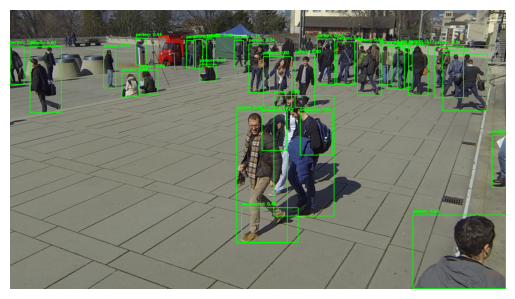

In [142]:
# display bounding boxes using opencv
def display_bboxes_opencv(image, bboxes, scores, categories):
    img_copy = image.copy()
    for bbox, score, category in zip(bboxes, scores, categories):
        x1, y1, x2, y2 = map(int, bbox)
        cv.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{category}: {score:.2f}"
        cv.putText(img_copy, label, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

display_bboxes_opencv(image_df['C1'][0], bboxes, scores, categories)

In [157]:
def track_objects(img_list, detection_model, time_since_update_threshold=2):
    tracker = DeepSort(
        max_age=5,  # Reduced from 30 - kills tracks faster when no detection
        max_iou_distance=0.8,  # Lower threshold for better matching
        n_init=1,  # Frames needed to confirm a track
    )
    all_tracks = []
    
    for image in img_list:
        bboxes, scores, categories = predict(image, detection_model)
        
        detections = []
        for bbox, score, cat in zip(bboxes, scores, categories):
            x1, y1, x2, y2 = bbox
            w, h = x2 - x1, y2 - y1
            detections.append(([x1, y1, w, h], score, cat))
        
        tracks = tracker.update_tracks(detections, frame=image)
        
        frame_tracks = []
        for track in tracks:
            # Only show tracks that have a detection in this frame
            if track.is_confirmed() and track.time_since_update <= time_since_update_threshold:
                track_id = track.track_id
                bbox = track.to_ltrb()
                confidence = track.get_det_conf()
                category = track.get_det_class()
                
                frame_tracks.append({
                    'track_id': track_id,
                    'bbox': bbox,
                    'confidence': confidence,
                    'category': category
                })
        
        all_tracks.append(frame_tracks)
    
    return all_tracks

def animate_tracks(image_df, all_tracks):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Color map for different track IDs
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    def update(frame_idx):
        ax.clear()
        
        # Display image
        image = image_df['C1'][frame_idx]
        ax.imshow(image)
        
        # Draw bounding boxes for each track
        for track in all_tracks[frame_idx]:
            track_id = track['track_id']
            x1, y1, x2, y2 = track['bbox']
            confidence = track['confidence']
            category = track['category']
            
            # Use track_id for consistent coloring
            color = colors[int(track_id) % len(colors)]
            
            # Draw bbox
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     linewidth=2, edgecolor=color, 
                                     facecolor='none')
            ax.add_patch(rect)
            
            # Add label
            if confidence is None:
                confidence = 0.0
            label = f'ID:{track_id} {category} {confidence:.2f}'
            ax.text(x1, y1-5, label, color=color, 
                   fontsize=10, weight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax.axis('off')
        ax.set_title(f'Frame {frame_idx + 1}/{len(all_tracks)}')
    
    anim = FuncAnimation(fig, update, frames=len(all_tracks), 
                        interval=100, repeat=True)
    plt.tight_layout()
    return anim

In [ ]:
img_list = image_df['C1'].tolist()
all_tracks = track_objects(img_list, detection_model)

# Usage:
save_path = 'tracked_animation.mp4'
anim = animate_tracks(image_df, all_tracks)
anim.save(save_path, writer='ffmpeg', fps=1, dpi=100)
plt.close()

# Display in IPython
from IPython.display import Video
Video(save_path, embed=True)

In [6]:
img1 = image_df['camera1'][1]
img2 = image_df['camera3'][1]

In [7]:
view1_result = get_sliced_prediction(
    image=img1,
    detection_model=detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
view1_pred = view1_result.object_prediction_list

view2_result = get_sliced_prediction(
    image=img2,
    detection_model=detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
view2_pred = view2_result.object_prediction_list

Performing prediction on 28 slices.
Performing prediction on 28 slices.


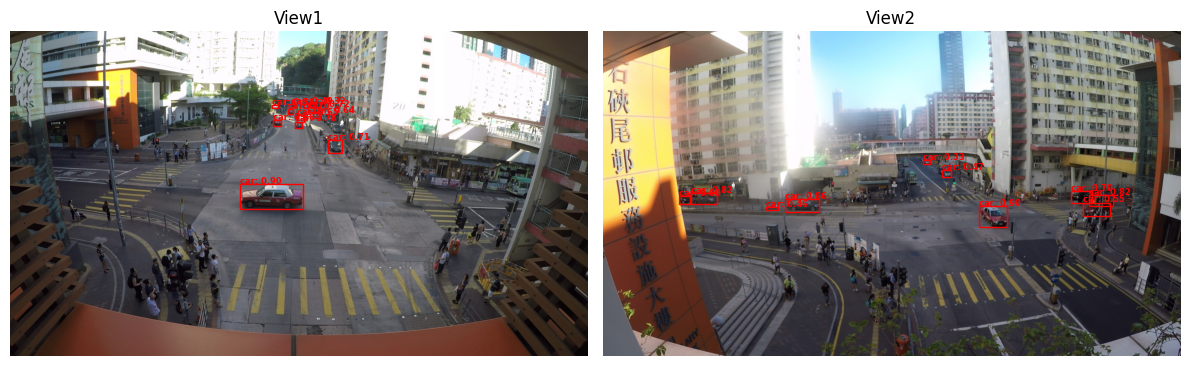

In [8]:
draw_predictions_multi(
    images=[img1, img2],
    predictions_list=[view1_pred, view2_pred],
    category='car',
    titles = ['View1', 'View2']
)

In [9]:
img1.shape

(1520, 2704, 3)

In [10]:
view1_pred.sort(key=lambda pred: pred.score.value, reverse=True)
view2_pred.sort(key=lambda pred: pred.score.value, reverse=True)

In [ ]:
bbox1 = view1_pred[0].bbox.to_xyxy()
x1C = (bbox1[0] + bbox1[2]) / 2
y1C = (bbox1[1] + bbox1[3]) / 2
bbox2 = view2_pred[0].bbox.to_xyxy()
x2C = (bbox2[0] + bbox2[2]) / 2
y2C = (bbox2[1] + bbox2[3]) / 2

print(view1_pred[0].score.value)
print(view2_pred[0].score.value)

print(x1C, y1C)
print(x2C, y2C)

# height = 1.65  # average car height in meters
height = find_height(x1C, y1C, x2C, y2C)
print(height)
print(Image2World("view1", x1C, y1C, height))
print(Image2World("view2", x2C, y2C, height))

0.8958714604377747
0.9049619436264038
1225.1996765136719 773.7371215820312
1827.7118682861328 866.6142272949219
1560
[np.float64(-5462.673926464462), np.float64(-3958.1398361938436), np.int64(1560)]
[np.float64(-1033.9345187611414), np.float64(-5886.170581650919), np.int64(1560)]


In [ ]:
# turn bounding boxes to world coordinates Image2World('view1', Xi, Yi, Zi)  

def world_coordinates_from_bboxes(pred, view):
    pass


bounding_data = [(pred.bbox.to_xyxy(), pred.score.value, pred.category.name) for pred in predictions]  



NameError: name 'predictions' is not defined

In [ ]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)